C:\Users\zhaoke\AppData\Local\Temp\ipykernel_11692\4104500072.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path)
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\zhaoke\AppData\Local\Temp\ipykernel_11692\4104500072.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path)
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


22050
22050
22050
1
1
1


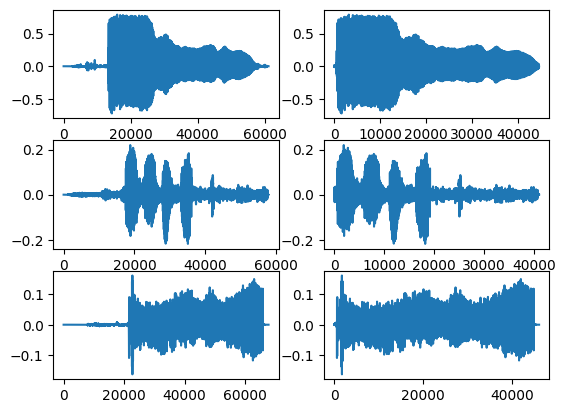

In [1]:
import matplotlib.pyplot as plt
import librosa
from tools import vad
wav_paths=["./datasets/test_xmj.m4a",
          "./datasets/test_gsy.m4a",
          "./datasets/test_zk.m4a"]
wavs = []
fine_wavs = []
for wav_path in wav_paths:
    y, sr = librosa.load(wav_path)
    print(sr)
    wavs.append(y)
plt.figure(1)
plt.subplot(3,2,1)
plt.plot(wavs[0])
plt.subplot(3,2,2)
plt.plot(vad(wavs[0], top_db=20, overlap=40))
plt.subplot(3,2,3)
plt.plot(wavs[1])
plt.subplot(3,2,4)
plt.plot(vad(wavs[1], top_db=20, overlap=40))
plt.subplot(3,2,5)
plt.plot(wavs[2])
plt.subplot(3,2,6)
plt.plot(vad(wavs[2], top_db=20, overlap=40))
plt.show()

In [1]:
import sys
sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/VoiceDiagnosis')
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from cls_model import CLSModel
from tools import vad

In [2]:
windowLength=255
fftLength=2046
hop_length=63
frame_length=8096

In [14]:
np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
clean_data = np.load('./datasets/clean_data.npy', allow_pickle=True)  # 原始音频
clean_labels = np.load('./datasets/clean_labels.npy')
noise_added = np.load('./datasets/noise_added.npy')  # 原始音频和noise相加
clean_pad = np.load('./datasets/clean_pad.npy')
denoised = np.load('./datasets/denoised_audio.npy')  # Unet预测的无噪音频

In [4]:
print(clean_data[0].shape)
print(clean_labels[0].shape)
print(noise_added[0].shape)
print(clean_pad[0].shape)
print(denoised[0].shape)

(3808,)
()
(3872,)
(3872,)
(3872, 1)


In [ ]:
stft_denoised = []
new_labels = []
for i in tqdm(range(len(denoised))):
    stft_denoised.append(librosa.feature.mfcc(y=np.reshape(denoised[i], (3872)), sr=8000, n_mfcc=26))
    new_labels.append(clean_labels[i])
    stft_denoised.append(librosa.feature.mfcc(y=np.reshape(clean_pad[i][:,np.newaxis], (3872)), sr=8000, n_mfcc=26))
    new_labels.append(clean_labels[i])
    stft_denoised.append(librosa.feature.mfcc(y=np.reshape(noise_added[i][:,np.newaxis], (3872)), sr=8000, n_mfcc=26))
    new_labels.append(clean_labels[i])
stft_denoised = np.array(stft_denoised)
clean_labels = np.array(new_labels)
stft_denoised.shape, clean_labels.shape

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [8]:
clean_labels = torch.from_numpy(clean_labels)
output_matrix = torch.zeros((clean_labels.shape[0], 4), device=device)
output_matrix = output_matrix.scatter_(1, clean_labels.unsqueeze(1).long().to(device), 1)
output_matrix

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]], device='cuda:0')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(stft_denoised, output_matrix,
                                                    random_state=98,
                                                    test_size=0.2,
                                                    shuffle=True)

In [10]:
class BaseDataset(Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels
        
    def __getitem__(self, ind):
        return torch.from_numpy(self.datas[ind]), self.labels[ind]

    def __len__(self):
        return len(self.labels)

trainset = BaseDataset(X_train, y_train)
testset = BaseDataset(X_test, y_test)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [ ]:
cl_model = CLSModel().to(device)
cl_model

class_loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cl_model.parameters(), lr=0.001)

old = 0
STD_acc = []
STD_loss = []
loss_line = []

for epoch_id in tqdm(range(300), desc="Train"):
    cl_model.train()
    loss_list = []
    for idx, (X_mel, y_mel) in enumerate(train_loader):
        optimizer.zero_grad()
        X_mel = X_mel.transpose(1, 2).to(device)
        y_mel = y_mel.to(device)
        # print(X_mel.shape)
        pred = cl_model(X_mel)
        loss_v = class_loss(pred, y_mel)
        loss_v.backward()
        loss_list.append(loss_v.item())
        optimizer.step()
    loss_line.append(np.array(loss_list).mean())
    cl_model.eval()
    with torch.no_grad():
        acc_list = []
        loss_list = []
        for idx, (X_mel, y_mel) in tqdm(enumerate(test_loader), desc="Valid"):
            X_mel = X_mel.transpose(1, 2).to(device)
            y_mel = y_mel.to(device)
            # print(X_mel.shape)
            pred = cl_model(X_mel)
            loss_eval = class_loss(pred, y_mel)
            # print(y_mel.argmax(-1))
            # print(pred.argmax(-1))
            acc_batch = metrics.accuracy_score(y_mel.argmax(-1).data.cpu().numpy(), pred.argmax(-1).data.cpu().numpy())
            acc_list.append(acc_batch)
            loss_list.append(loss_eval.item())
        acc_per = np.array(acc_list).mean()
        
        STD_acc.append(acc_per)
        STD_loss.append(np.array(loss_list).mean())
        if acc_per > old:
            old = acc_per
            if acc_per > 0.9:
                print(f"Epoch[{epoch_id}]: {acc_per}")
                torch.save(cl_model.state_dict(), f"./ckpt/cls_model_{epoch_id}.pt")

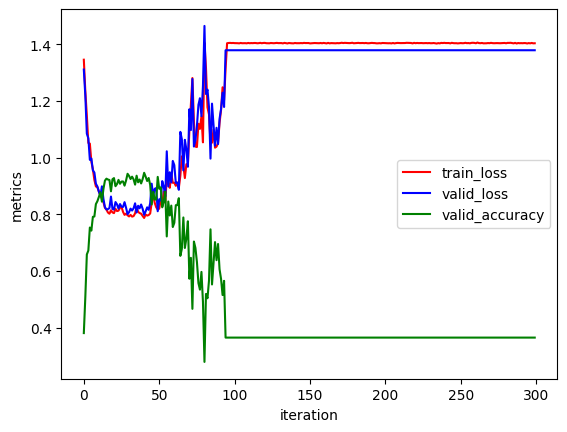

In [13]:
plt.figure(0)
plt.plot(range(len(loss_line)), loss_line, c="red", label="train_loss")
plt.plot(range(len(STD_loss)), STD_loss, c="blue", label="valid_loss")
plt.plot(range(len(STD_acc)), STD_acc, c="green", label="valid_accuracy")
plt.xlabel("iteration")
plt.ylabel("metrics")
plt.legend()
plt.show()